# Zadanie: projekt końcowy
Wiesz już, jak powinien wyglądać projekt końcowy. Wykonaj go samodzielnie dla problemu klasyfikacji i wykorzystaj do tego zbiór danych default_of_credit_card_clients.xls. Pobierz go teraz. Twoim problemem do rozwiązania jest klasyfikacja, czy przyznać kartę kredytową.

Poniżej opis zmiennych:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .; X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


Miej na uwadze, że w danych mogą pojawić się błędy. Projekt wykonany umieść na platformie GitHub i prześlij go Mentorowi. Wykorzystać możesz całą wiedzę zdobytą do tej pory.

Powodzenia! Trzymamy kciuki!

In [1]:
# data manipulation
import numpy as np
import pandas as pd
import datetime as dt
import time
from math import sqrt
from tqdm import tqdm
import holidays
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# feature selection
from sklearn.feature_selection import RFECV
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
# interpretowalność modelu
import shap
shap.initjs()
# zapisanie modelu
import joblib
# settings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [67]:
dataframe = pd.read_excel('default_of_credit_card_clients.xls', header=1)
# dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [68]:
dataframe.columns.tolist()

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

###### Mamy błąd przy historii płatności, kolumna zamiast nazywać się PAY_1 ma nazwę PAY_0, zmienimy to.

In [69]:
dataframe.rename(columns={'PAY_0':'PAY_1'}, inplace=True)

In [70]:
dataframe.columns[5:13]

Index(['AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1'],
      dtype='object')

##### Czy są wartości brakujące?

In [72]:
dataframe.isnull().mean()*100

ID                            0.0
LIMIT_BAL                     0.0
SEX                           0.0
EDUCATION                     0.0
MARRIAGE                      0.0
AGE                           0.0
PAY_1                         0.0
PAY_2                         0.0
PAY_3                         0.0
PAY_4                         0.0
PAY_5                         0.0
PAY_6                         0.0
BILL_AMT1                     0.0
BILL_AMT2                     0.0
BILL_AMT3                     0.0
BILL_AMT4                     0.0
BILL_AMT5                     0.0
BILL_AMT6                     0.0
PAY_AMT1                      0.0
PAY_AMT2                      0.0
PAY_AMT3                      0.0
PAY_AMT4                      0.0
PAY_AMT5                      0.0
PAY_AMT6                      0.0
default payment next month    0.0
dtype: float64

###### Nie ma wartości brakujących

##### Czy są duplikaty dla ID?

In [73]:
dataframe.loc[dataframe.duplicated(subset='ID', keep=False), :]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month


###### Klienci banku się nie powtarzają w tabeli.

#### Czy ID są posortowane?

In [74]:
(dataframe['ID'] == dataframe['ID'].sort_values()).all()

True

#### Jaki jest rozkład naszych danych?

In [75]:
dataframe.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


#### Obliczę średnią z historii płatności, żeby sprawdzić czy zadłużenie jest spłacane, sprawdzę również średnią na rachunku bankowym, oraz średnie kwoty jakimi jest spłacane zadłużenie.

In [76]:
from statistics import mean

def history_mean(row):
    return row[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean().round(2)

def bill_amount_mean(row):
    return row[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean().round(2)

def payment_amount_mean(row):
    return row[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean().round(2)

In [78]:
dataframe['mean_history_payment'] = dataframe.apply(lambda row: history_mean(row), axis=1)
dataframe['mean_bill_amount'] = dataframe.apply(lambda row: bill_amount_mean(row), axis=1)
dataframe['mean_payment_amount'] = dataframe.apply(lambda row: payment_amount_mean(row), axis=1)

dataframe[['mean_history_payment', 'mean_bill_amount', 'mean_payment_amount']].head()

,mean_history_payment,mean_bill_amount,mean_payment_amount
0,-0.33,1284.00,114.83
1,0.50,2846.17,833.33
2,0.00,16942.17,1836.33
3,0.00,38555.67,1398.00
4,-0.33,18223.17,9841.50


In [79]:
dataframe

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,mean_history_payment,mean_bill_amount,mean_payment_amount
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,689,0,0,0,0,1,-0.33,1284.00,114.83
1,2,120000,2,2,2,26,-1,2,0,0,...,0,1000,1000,1000,0,2000,1,0.50,2846.17,833.33
2,3,90000,2,2,2,34,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,0.00,16942.17,1836.33
3,4,50000,2,2,1,37,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,0.00,38555.67,1398.00
4,5,50000,1,2,1,57,-1,0,-1,0,...,2000,36681,10000,9000,689,679,0,-0.33,18223.17,9841.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,8500,20000,5003,3047,5000,1000,0,0.00,120891.50,7091.67
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,1837,3526,8998,129,0,0,0,-0.67,3530.33,2415.00
29997,29998,30000,1,2,2,37,4,3,2,-1,...,0,0,22000,4200,2000,3100,1,1.33,11749.33,5216.67
29998,29999,80000,1,3,1,41,1,-1,0,0,...,85900,3409,1178,1926,52964,1804,1,-0.17,44435.17,24530.17


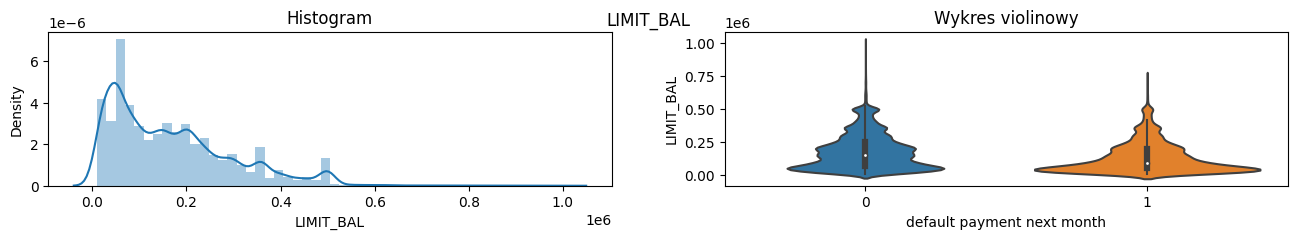

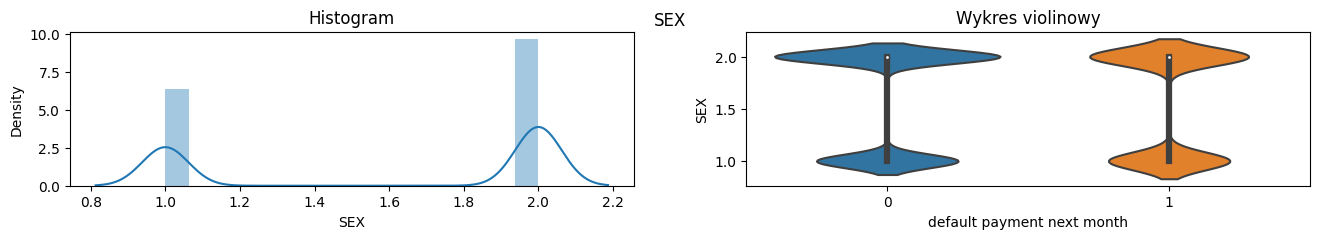

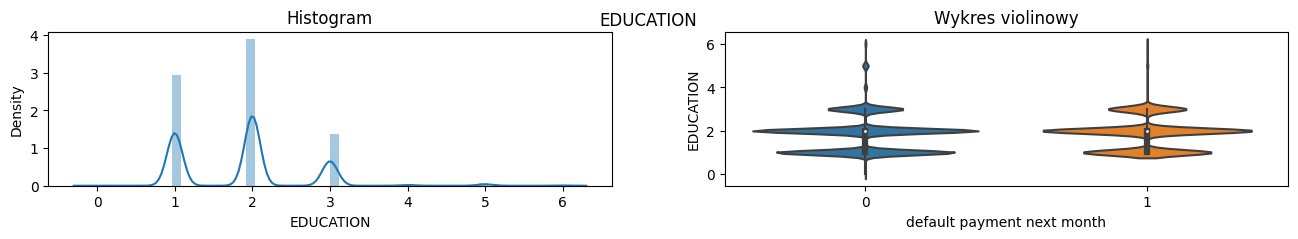

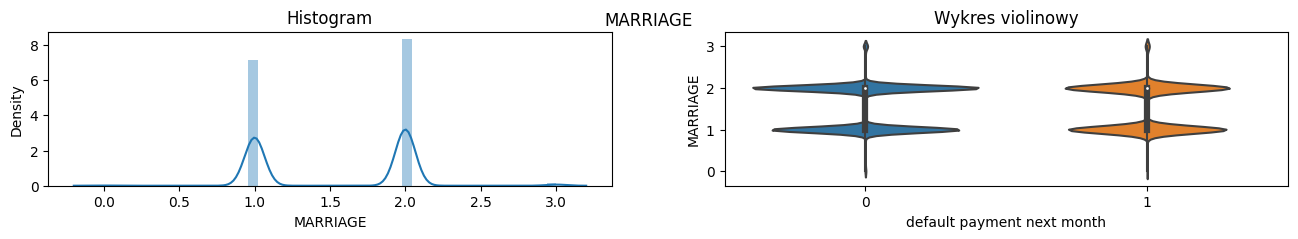

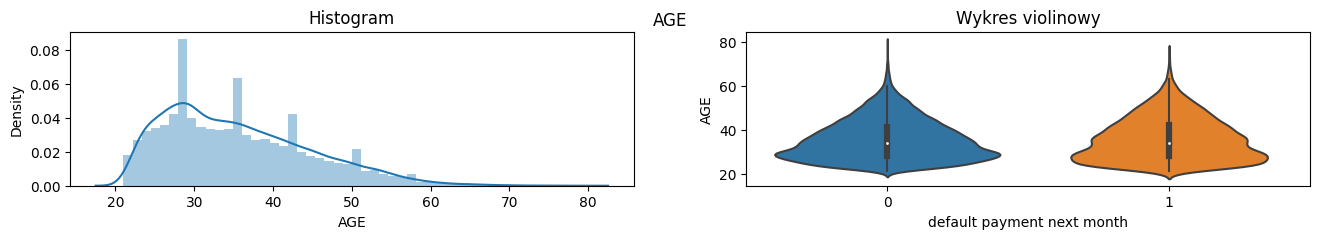

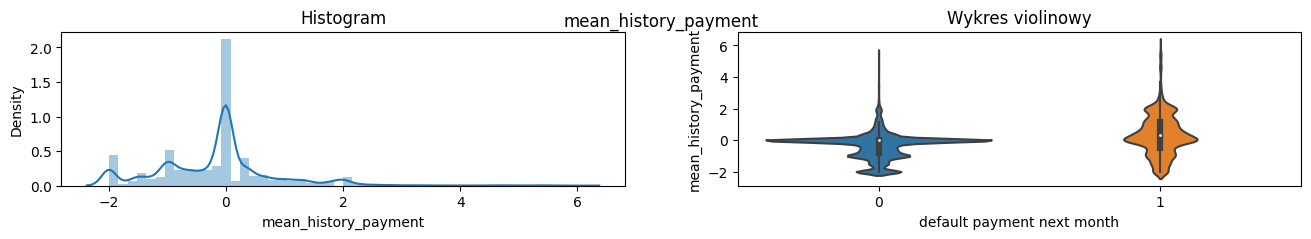

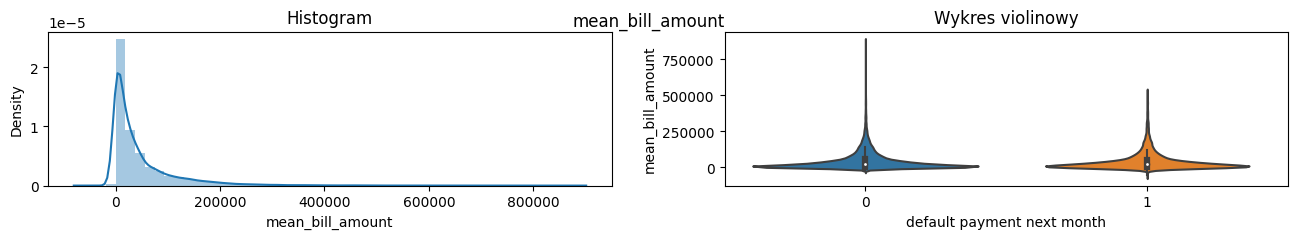

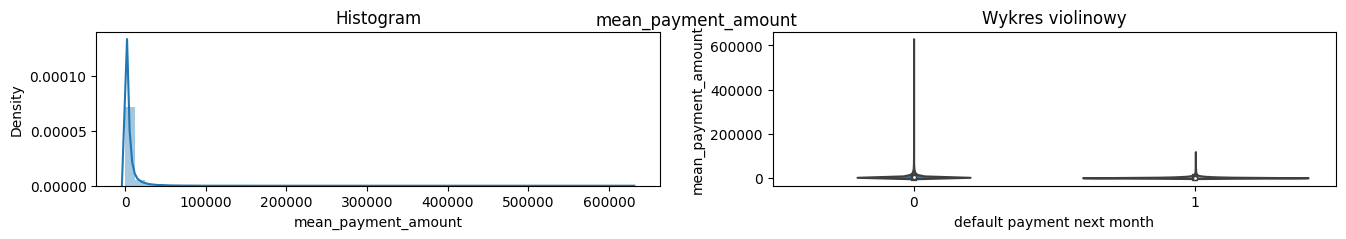

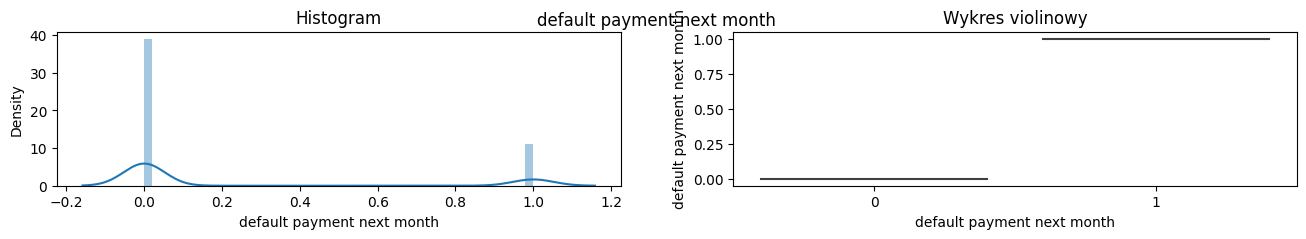

In [80]:
for name in dataframe[['LIMIT_BAL','SEX','EDUCATION', 'MARRIAGE', 'AGE', 
                       'mean_history_payment', 'mean_bill_amount', 'mean_payment_amount',
                       'default payment next month']]:
    fig = plt.figure(figsize=(16, 2))
    fig.suptitle(name, fontsize=12)
    plt.subplot(121)
    sns.distplot(dataframe[name], kde=True, rug=False)
    plt.title('Histogram')
    plt.subplot(122)
    sns.violinplot(y=dataframe[name], x=dataframe['default payment next month'])
    plt.title('Wykres violinowy')
    plt.show()

###### Tak jak mogłibyśmy podejżewać, im wartość zadłużenia jest mniejsza, tym większe szanse na otrzymanie karty kredytowej. Karty otrzymuje również więcej kobiet, ale jest to zapewne związane z tym, że więcej kobiet niż mężczyzn wnioskuje o kartę. Głównymi klientami banku są osoby z wykszłatceniem 2 - university oraz 1 - graduate school, tacy też dostają najczęściej kartę, co związane może być z tym, że zaraz po skzole nie mają jeszcze wystarczających zasobów gotówkowych przez opłaty za ukończną szkołę, by regulować swoje płatności na bierząco i potrzebują karty kredytowej. Wśród klientów, nie ma dużej rozbieżności przy tym, czy są w związku małżeńskim czy nie. Jak już można zauważyć po wykształceniu głównymi klientami są osoby młode, stąd większość otrzymująca karty są to osoby w wieku 25-30 lat. Wykres średniej wartości pieniędzy na rachunku oraz średniej wysokości raty są podobne , można zatem stwierdzić że Ci którzy mają duże środki mają róenież wysoką rate kredytu co nie kwalifikuje ich do otrzymania karty kredytowej.

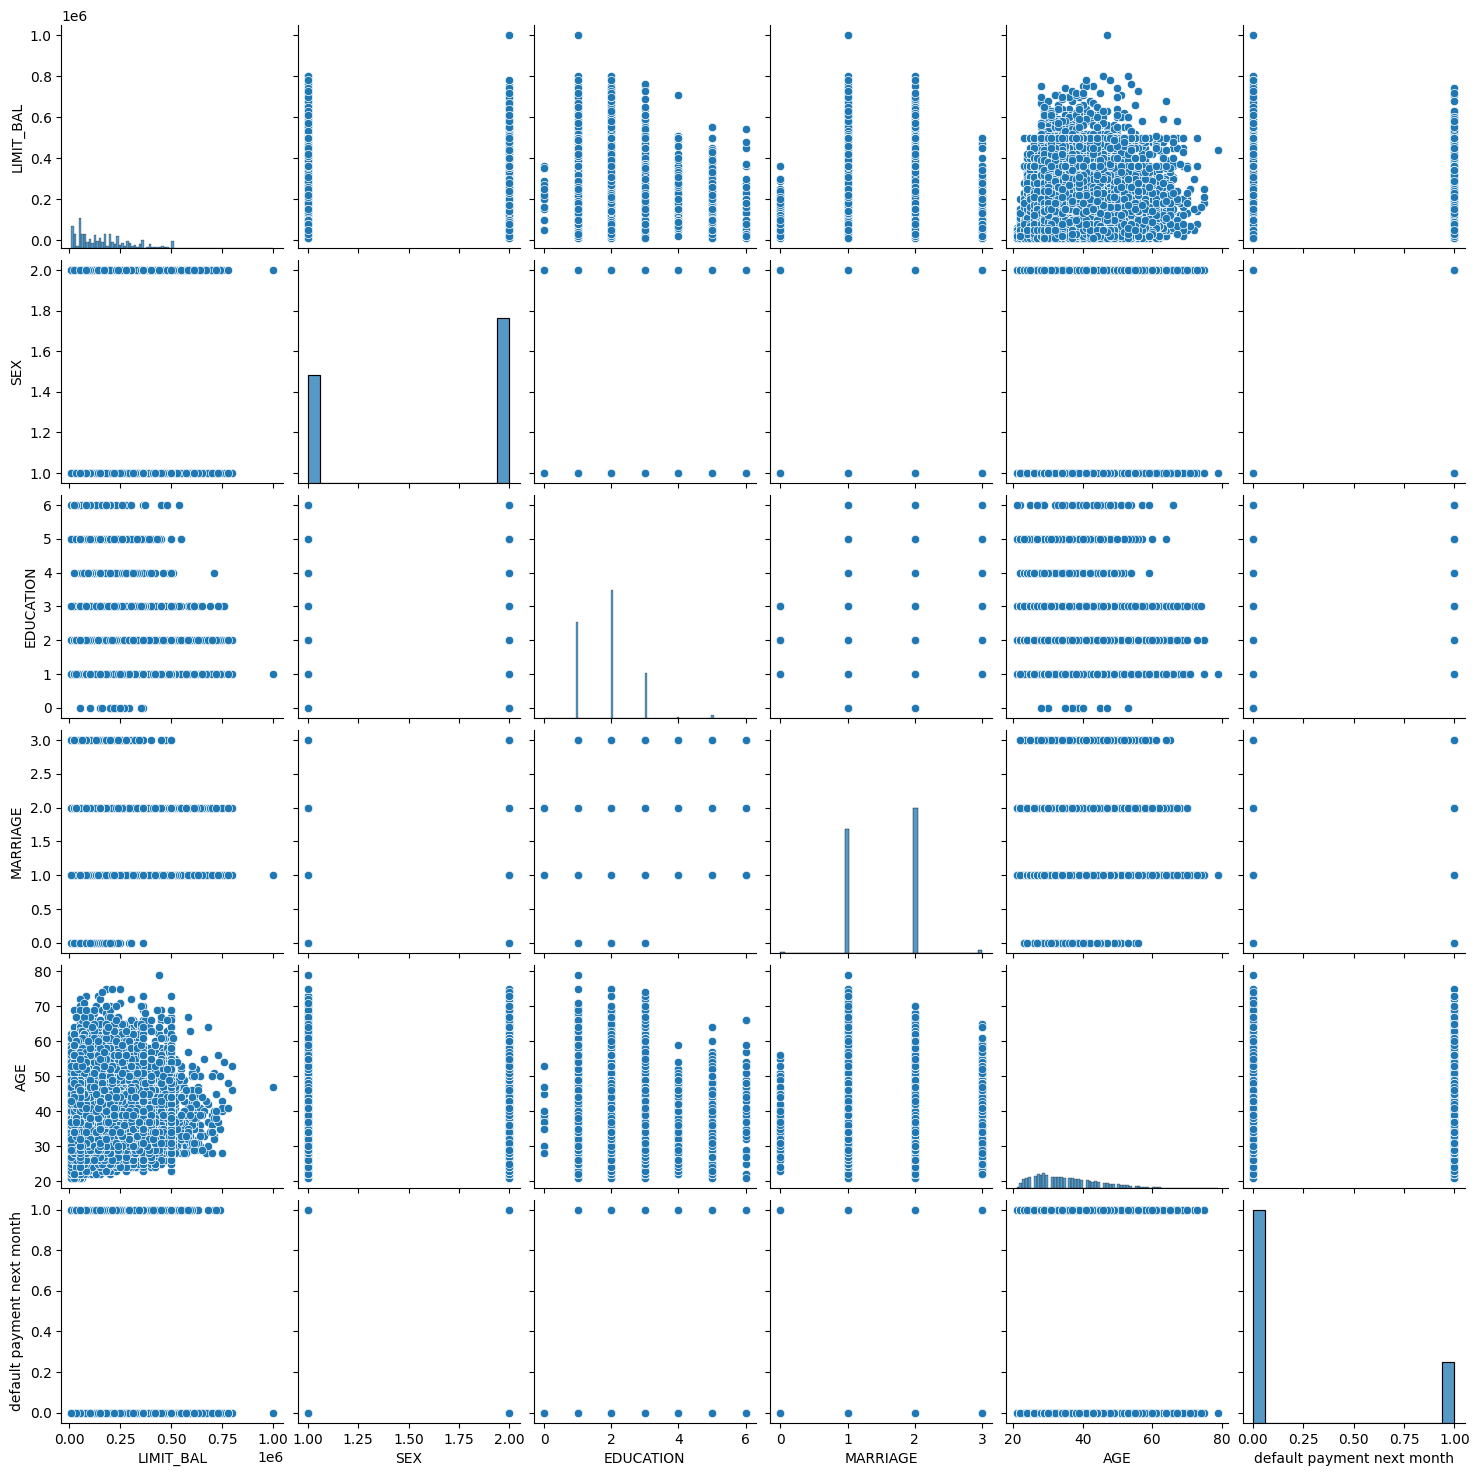

In [84]:
sns.pairplot(dataframe[['LIMIT_BAL','SEX','EDUCATION', 'MARRIAGE', 'AGE', 
                       'default payment next month']])

In [85]:
dataframe

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,mean_history_payment,mean_bill_amount,mean_payment_amount
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,689,0,0,0,0,1,-0.33,1284.00,114.83
1,2,120000,2,2,2,26,-1,2,0,0,...,0,1000,1000,1000,0,2000,1,0.50,2846.17,833.33
2,3,90000,2,2,2,34,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,0.00,16942.17,1836.33
3,4,50000,2,2,1,37,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,0.00,38555.67,1398.00
4,5,50000,1,2,1,57,-1,0,-1,0,...,2000,36681,10000,9000,689,679,0,-0.33,18223.17,9841.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,8500,20000,5003,3047,5000,1000,0,0.00,120891.50,7091.67
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,1837,3526,8998,129,0,0,0,-0.67,3530.33,2415.00
29997,29998,30000,1,2,2,37,4,3,2,-1,...,0,0,22000,4200,2000,3100,1,1.33,11749.33,5216.67
29998,29999,80000,1,3,1,41,1,-1,0,0,...,85900,3409,1178,1926,52964,1804,1,-0.17,44435.17,24530.17


##### Podział danych na X i y

In [96]:
X = dataframe.drop(['default payment next month', 'ID'], axis=1)
y = dataframe['default payment next month']

In [97]:
print('X:')
display(X)
print('\ny:')
display(y)

X:


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,mean_history_payment,mean_bill_amount,mean_payment_amount
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,689,0,0,0,0,-0.33,1284.00,114.83
1,120000,2,2,2,26,-1,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,0.50,2846.17,833.33
2,90000,2,2,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0.00,16942.17,1836.33
3,50000,2,2,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0.00,38555.67,1398.00
4,50000,1,2,1,57,-1,0,-1,0,0,...,19131,2000,36681,10000,9000,689,679,-0.33,18223.17,9841.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,15980,8500,20000,5003,3047,5000,1000,0.00,120891.50,7091.67
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,0,1837,3526,8998,129,0,0,-0.67,3530.33,2415.00
29997,30000,1,2,2,37,4,3,2,-1,0,...,19357,0,0,22000,4200,2000,3100,1.33,11749.33,5216.67
29998,80000,1,3,1,41,1,-1,0,0,0,...,48944,85900,3409,1178,1926,52964,1804,-0.17,44435.17,24530.17



y:


0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment next month, Length: 30000, dtype: int64

In [98]:
pd.Series(y).value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

In [99]:
from scipy import stats

corr_dict = {}
for col in X.columns:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

PAY_1                   0.324794
mean_history_payment    0.281957
PAY_2                   0.263551
PAY_3                   0.235253
PAY_4                   0.216614
PAY_5                   0.204149
PAY_6                   0.186866
EDUCATION               0.028006
AGE                     0.013890
BILL_AMT6              -0.005372
BILL_AMT5              -0.006760
BILL_AMT4              -0.010156
mean_bill_amount       -0.012691
BILL_AMT3              -0.014076
BILL_AMT2              -0.014193
BILL_AMT1              -0.019644
MARRIAGE               -0.024339
SEX                    -0.039961
PAY_AMT6               -0.053183
PAY_AMT5               -0.055124
PAY_AMT3               -0.056250
PAY_AMT4               -0.056827
PAY_AMT2               -0.058579
PAY_AMT1               -0.072929
mean_payment_amount    -0.102354
LIMIT_BAL              -0.153520
dtype: float64

##### Podział danych na zbiór treningowy i testowy

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, 
                                                    stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], 
                                                            X_test.shape[0]))

Treningowe obserwacje: 24000
Testowe obserwacje: 6000


##### Selekcja zmiennych

In [101]:
importances = RandomForestRegressor(n_estimators=1000, max_depth=20, 
                                    n_jobs=-1).fit(X_train, y_train).feature_importances_
features = pd.concat([pd.DataFrame(X_train.columns, columns=['feat']),
                      pd.DataFrame(importances, columns=['importance'])], 
                      axis=1).sort_values(by='importance', ascending=False)
features = features[features['importance']>0.0075]
features.loc[features['feat'].str.contains('mean'), 'Busket'] = 'mean'
features.loc[features['feat'].str.contains('std'), 'Busket'] = 'std'
features.loc[features['feat'].str.contains('min'), 'Busket'] = 'min'
features.loc[features['feat'].str.contains('max'), 'Busket'] = 'max'
display(features)

features = features[(~features.duplicated(subset='Busket', keep='first'))|(features['Busket'].isnull())]
features = list(features['feat'].values)

print(f'Liczba zmiennych: {len(features)}')
print(f'Zmienne: {features}')

,feat,importance,Busket
5,PAY_1,0.185400,NaN
25,mean_payment_amount,0.067761,mean
4,AGE,0.066339,NaN
23,mean_history_payment,0.058427,mean
0,LIMIT_BAL,0.052036,NaN
11,BILL_AMT1,0.050155,NaN
24,mean_bill_amount,0.042820,mean
22,PAY_AMT6,0.040927,NaN
18,PAY_AMT2,0.038749,NaN
19,PAY_AMT3,0.038431,NaN


Liczba zmiennych: 20
Zmienne: ['PAY_1', 'mean_payment_amount', 'AGE', 'LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT6', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT1', 'BILL_AMT6', 'BILL_AMT2', 'PAY_AMT5', 'PAY_AMT4', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'EDUCATION', 'PAY_2', 'MARRIAGE', 'SEX']


###### Mamy już wyselekcjonowany zbiór cech, zmniejszyliśmy go o ponad 2/3. Wyfiltrujmy z X tylko te zmienne, które wybrano podczas selekcji cech.

In [102]:
X_train = X_train[features]
X_test = X_test[features]

##### Regresja logistyczna

In [117]:
from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack

def plot_classification_surface(X_plot, y_plot, trained_model):
    plt.figure(figsize=(12, 7))

    # określenie granic zbioru
    min1, max1 = X_plot[:, 0].min()-1, X_plot[:, 0].max()+1
    min2, max2 = X_plot[:, 1].min()-1, X_plot[:, 1].max()+1

    # skalowanie dla obu osi
    x1grid = arange(min1, max1, 0.1)
    x2grid = arange(min2, max2, 0.1)

    # utworzenie siatki
    xx, yy = meshgrid(x1grid, x2grid)

    # przetworzenie siatki w wektor
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # stworzenie zmiennych objaśniających dla modelu
    grid = hstack((r1,r2))

    # predykcja modelu zbioru
    yhat = trained_model.predict(grid)

    # przetworzenie predykcji na decyzji dla konkretnego punktu wykresu
    zz = yhat.reshape(xx.shape)

    # wizualizacja siatki z przyporządkowaną klasą
    plt.contourf(xx, yy, zz, cmap='Paired')

    # tworzenie wykresu punktowego dla klas ze zbioru X
    for class_value in range(2):

        # przyporządkowanie klasy (y) do obsewacji (X)
        row_ix = where(y_plot == class_value)

        # stworzenie wykresu punktowego
        plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, 
                    label=class_value)

    # wizualizacja wykresu
    plt.legend(loc='upper right')
    plt.show()

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

#### Funkcja, która oblicza najważniejsze metryki oraz rysuje wykresy.

In [119]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)
model_lr = LogisticRegression()
model_lr.fit(X_train_standardized, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      4673
           1       0.74      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.78      0.61      0.63      6000
weighted avg       0.80      0.81      0.77      6000



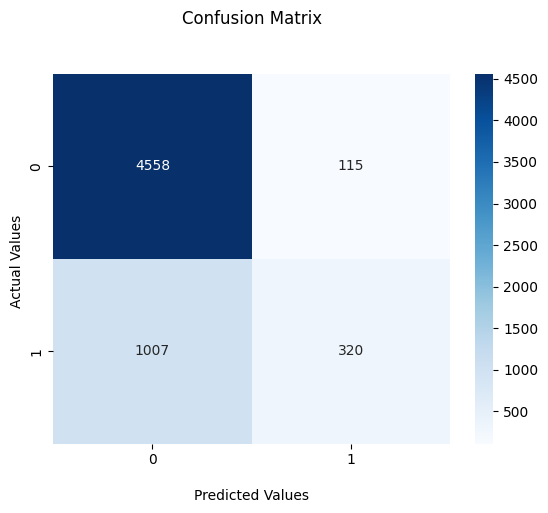

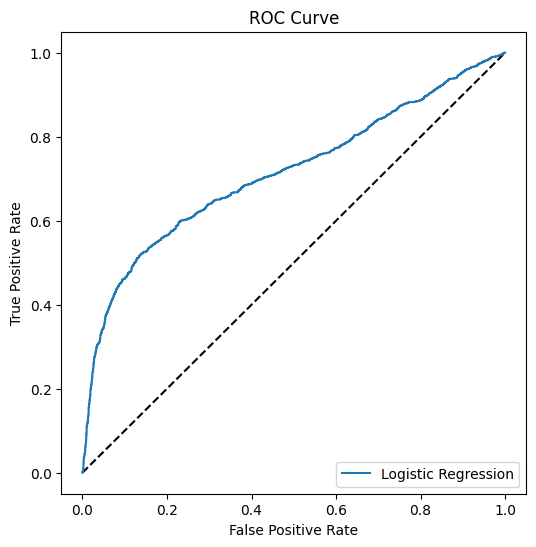

,Model,F1_score,AUC
0,Logistic Regression,0.363224,0.714001


In [121]:
predictions_lr = model_lr.predict(X_test_standardized)
calculate_metrics(model_lr, 'Logistic Regression', X_test_standardized, y_test)

#### KNN (K Nearest Neighbours) – K najbliższych sąsiadów

In [122]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors= int(X_train_standardized.shape[0]*0.001))
model_knn.fit(X_train_standardized, y_train)

KNeighborsClassifier(n_neighbors=24)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.67      0.32      0.43      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000



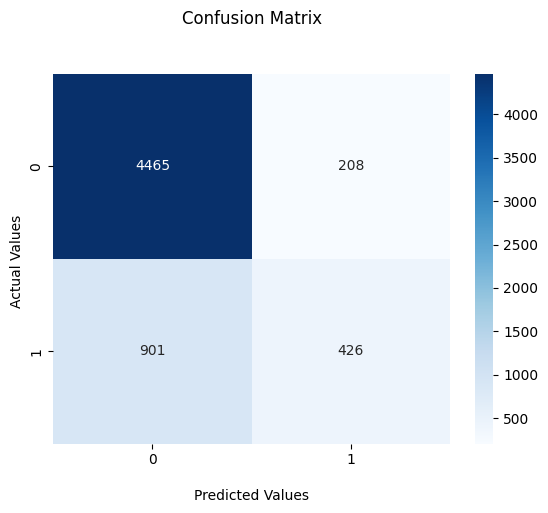

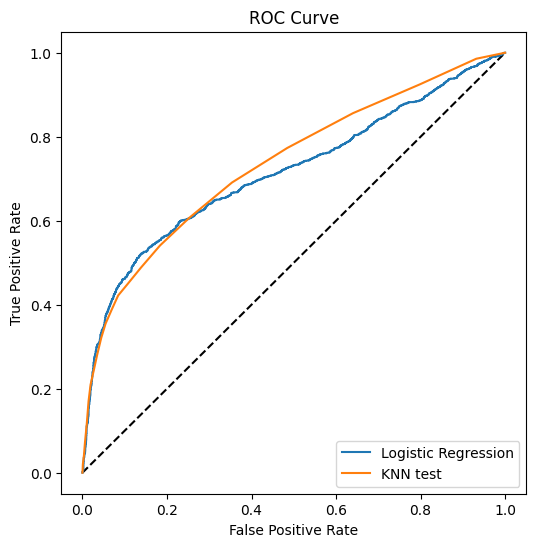

,Model,F1_score,AUC
0,Logistic Regression,0.363224,0.714001
1,KNN test,0.434472,0.735449


In [123]:
calculate_metrics(model_knn, 'KNN test', X_test_standardized, y_test)

#### Drzewo decyzyjne

In [125]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(max_depth=7, min_samples_leaf=int(
                X_train.shape[0]*0.002))
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=48)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.69      0.36      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.68      6000
weighted avg       0.81      0.82      0.80      6000



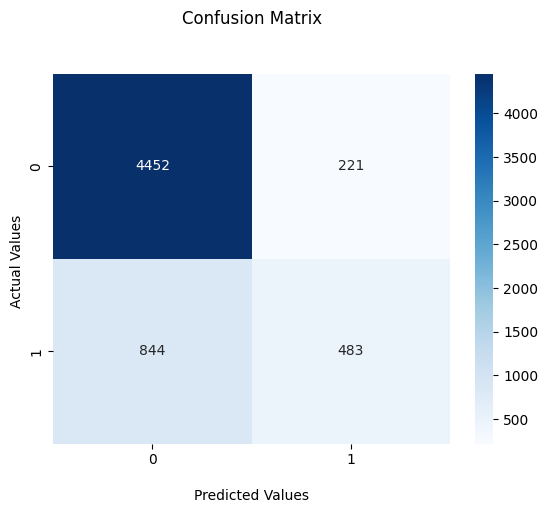

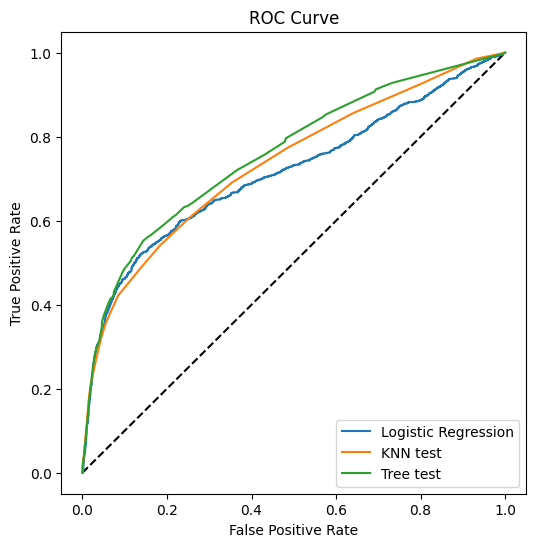

,Model,F1_score,AUC
0,Logistic Regression,0.363224,0.714001
1,KNN test,0.434472,0.735449
2,Tree test,0.475628,0.759272


In [126]:
calculate_metrics(model_tree, 'Tree test', X_test, y_test)

#### SVM (Support Vector Machines) - Maszyna wektorów nośnych

In [127]:
from sklearn.svm import SVC

model_svm = SVC(kernel='rbf', probability=True)
model_svm.fit(X_train_standardized, y_train)

SVC(probability=True)

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      4673
           1       0.73      0.31      0.43      1327

    accuracy                           0.82      6000
   macro avg       0.78      0.64      0.66      6000
weighted avg       0.81      0.82      0.79      6000



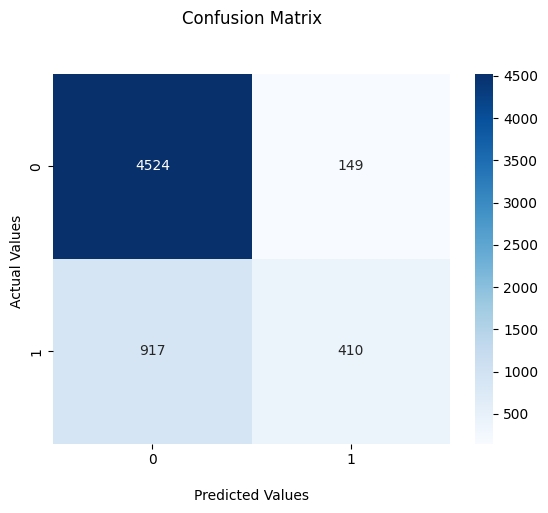

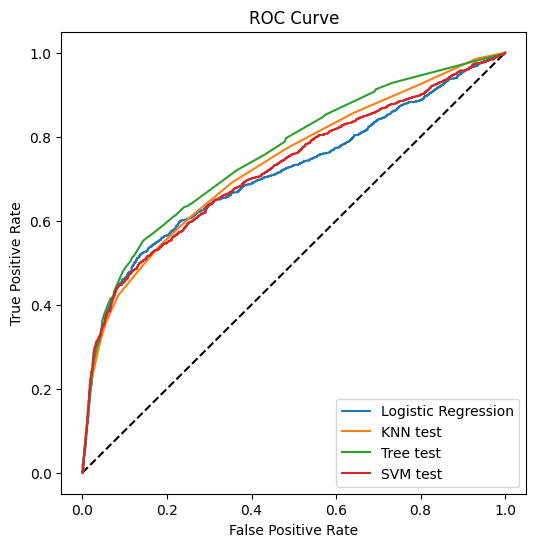

,Model,F1_score,AUC
0,Logistic Regression,0.363224,0.714001
1,KNN test,0.434472,0.735449
2,Tree test,0.475628,0.759272
3,SVM test,0.434783,0.724146


In [128]:
calculate_metrics(model_svm, 'SVM test', X_test_standardized, y_test)

#### Random Forest – Las drzew decyzyjnych

In [129]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(n_estimators=100, max_depth=5, 
                min_samples_leaf=int(X_train.shape[0]*0.020))
model_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=480)

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      4673
           1       0.75      0.23      0.35      1327

    accuracy                           0.81      6000
   macro avg       0.78      0.60      0.62      6000
weighted avg       0.80      0.81      0.77      6000



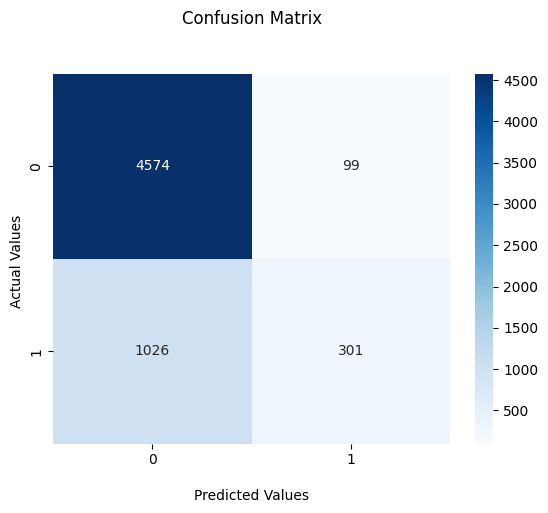

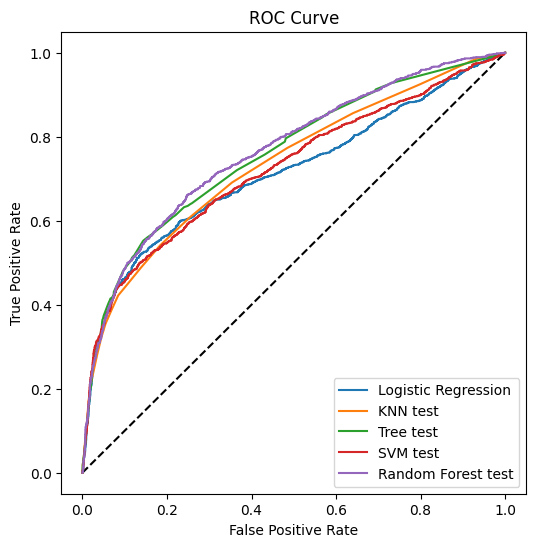

,Model,F1_score,AUC
0,Logistic Regression,0.363224,0.714001
1,KNN test,0.434472,0.735449
2,Tree test,0.475628,0.759272
3,SVM test,0.434783,0.724146
4,Random Forest test,0.348581,0.766504


In [130]:
calculate_metrics(model_forest, 'Random Forest test', X_test, y_test)

#### Boosting - AdaBoost

In [131]:
from sklearn.ensemble import AdaBoostClassifier

model_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                    n_estimators=1000)
model_adaboost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=1000)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.70      0.33      0.45      1327

    accuracy                           0.82      6000
   macro avg       0.77      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000



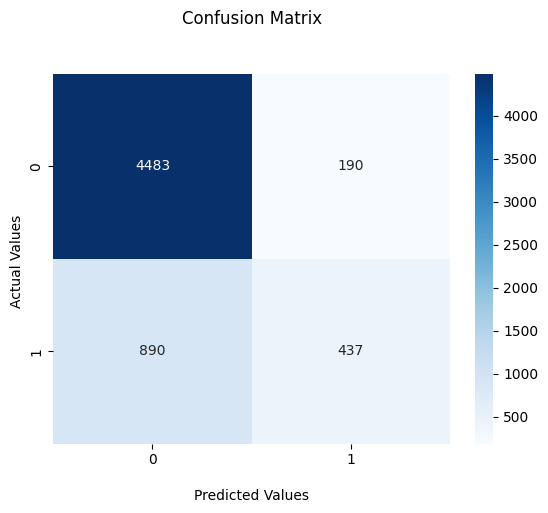

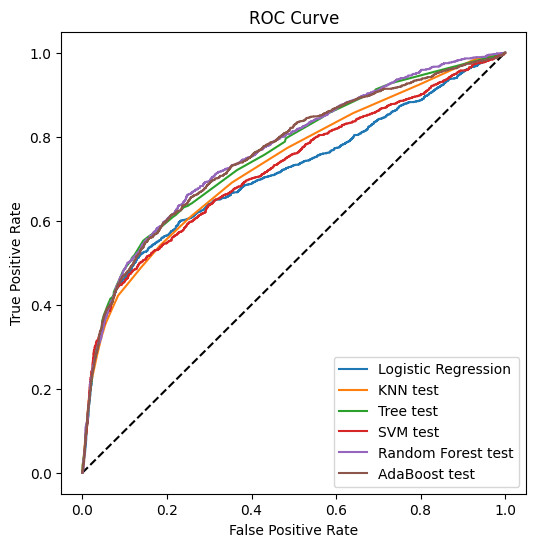

,Model,F1_score,AUC
0,Logistic Regression,0.363224,0.714001
1,KNN test,0.434472,0.735449
2,Tree test,0.475628,0.759272
3,SVM test,0.434783,0.724146
4,Random Forest test,0.348581,0.766504
5,AdaBoost test,0.447288,0.761240


In [132]:
calculate_metrics(model_adaboost, 'AdaBoost test', X_test, y_test)

#### Ensembling - Zespół klasyfikatorów

In [133]:
from sklearn.ensemble import VotingClassifier

model_voting = VotingClassifier(estimators=[('Tree', model_tree),
                                            ('Random Forest', model_forest),
                                            ('AdaBoost', model_adaboost)],
                                voting='soft')

model_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('Tree',
                              DecisionTreeClassifier(max_depth=7,
                                                     min_samples_leaf=48)),
                             ('Random Forest',
                              RandomForestClassifier(max_depth=5,
                                                     min_samples_leaf=480)),
                             ('AdaBoost',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                 n_estimators=1000))],
                 voting='soft')

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.69      0.33      0.45      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000



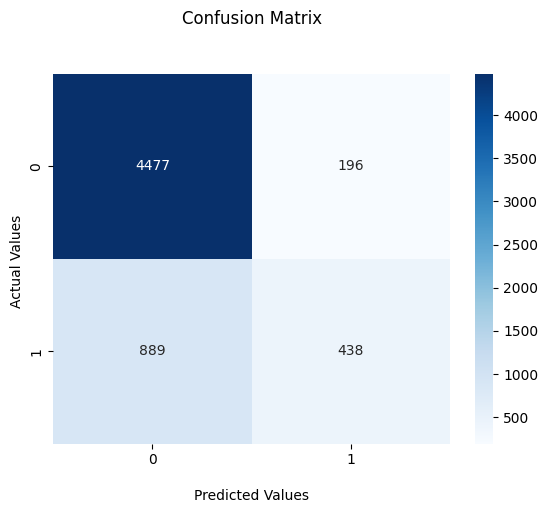

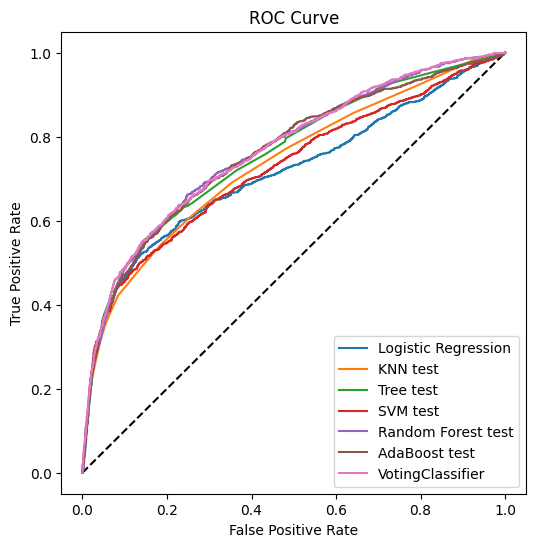

,Model,F1_score,AUC
0,Logistic Regression,0.363224,0.714001
1,KNN test,0.434472,0.735449
2,Tree test,0.475628,0.759272
3,SVM test,0.434783,0.724146
4,Random Forest test,0.348581,0.766504
5,AdaBoost test,0.447288,0.761240
6,VotingClassifier,0.446711,0.768345


In [134]:
calculate_metrics(model_voting, 'VotingClassifier', X_test, y_test)

#### Klasyfikacja na podstawie wielu zmiennych

In [135]:
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
params_rf = {'max_depth': [3, 5, 10, 20],
             'min_samples_leaf': [3, 5, 10, 15]}
rf_gridsearch = GridSearchCV(random_forest,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameter: {'max_depth': 20, 'min_samples_leaf': 3}


              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.69      0.36      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.77      0.66      0.69      6000
weighted avg       0.81      0.82      0.80      6000



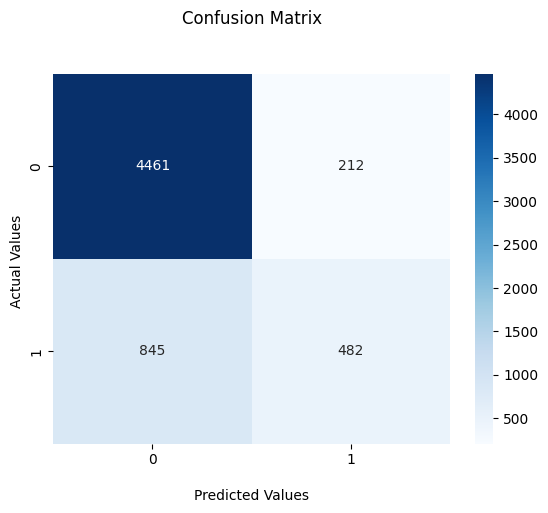

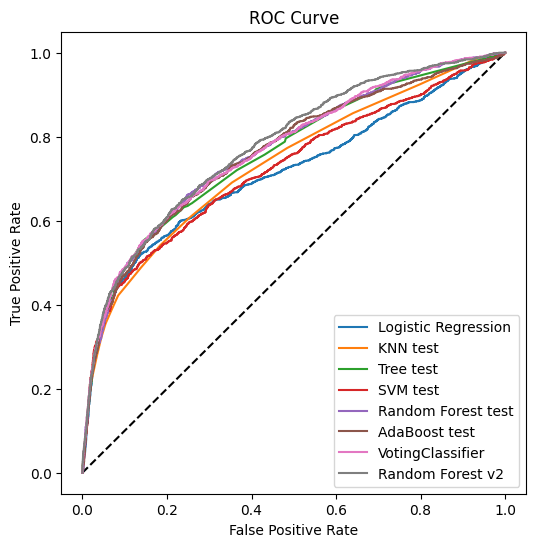

,Model,F1_score,AUC
0,Logistic Regression,0.363224,0.714001
1,KNN test,0.434472,0.735449
2,Tree test,0.475628,0.759272
3,SVM test,0.434783,0.724146
4,Random Forest test,0.348581,0.766504
5,AdaBoost test,0.447288,0.761240
6,VotingClassifier,0.446711,0.768345
7,Random Forest v2,0.476992,0.778759


In [136]:
calculate_metrics(rf_model_v2, 'Random Forest v2', X_test, y_test)

In [ ]:
random_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1))
params_adaboost= {'n_estimators': [20, 50, 100, 200],
             'learning_rate': [0.0, 0.2, 0.6, 1.0]}
adaboost_gridsearch = GridSearchCV(random_adaboost,
                             params_adaboost,
                             scoring='f1_macro',
                             cv=5)
adaboost_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', adaboost_gridsearch.best_params_)
adaboost_model_v2 = adaboost_gridsearch.best_estimator_

In [ ]:
calculate_metrics(adaboost_model_v2, 'Random AdaBoost v2', X_test, y_test)